## Importing Essentials Libraries

In [1]:
import os

# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn



# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:

general_path = '/home/bishal/bishal/major_project/baby_cry_classification'
dirs = list(os.listdir(f'{general_path}/archive/train'))
print(dirs)

['awake', 'hug', 'hungry', 'sleepy', 'uncomfortable']


In [3]:
# Numbers of files in each sample
sum=0
for dir in dirs:
    print(f'{dir} ========> {len(os.listdir(f"{general_path}/archive/train/{dir}"))}')
    sum+= len(os.listdir(f"{general_path}/archive/train/{dir}"))
print(f'\n\nthe total numbers of data ======> {sum}')

awake ========> 160
hug ========> 160
hungry ========> 160
sleepy ========> 144
uncomfortable ========> 160


the total numbers of data ======> 784


### librosa.load(path, *, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='soxr_hq')
* Load an audio file as a floating point time series.
* Audio will be automatically resampled to the given rate (default sr=22050).


* Returns
* y=np.ndarray [shape=(n,) or (…, n)]    audio time series

* sr=number > 0 [scalar] sampling rate of y



Audio sounds can be thought of as an one-dimensional vector that stores numerical values corresponding to each sample. The time-series plot is a two dimensional plot of those sample values as a function of time.

In [4]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/archive/train/awake/awake_0.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (Hz):', sr, '\n')

# Verify length of the audio
print(f'Length of Audio: {np.shape(y)[0]/sr}')

y: [ 0.000589   -0.00057987 -0.00011253 ...  0.02128213  0.01166966
  0.        ] 

y shape: (347391,) 

Sample Rate (Hz): 22050 

Length of Audio: 15.75469387755102


## Trim leading and trailing silence from an audio signal (silence before and after the actual audio)

### librosa.effects.trim(y, *, top_db=60, ref=<function amax>, frame_length=2048, hop_length=512, aggregate=<function amax>)
    ref:number or callable
The reference amplitude. By default, it uses np.max and compares to the peak amplitude in the signal.
    
    frame_lengtha:int > 0
The number of samples per analysis frame
    
    hop_length:int > 0
The number of samples between analysis frames
    
    
    Returns:
y_trimmed= numpy ndarrya =np.ndarray, shape=(…, m)
The trimmed signal
    
    index=np.ndarray, shape=(2,)
the interval of y corresponding to the non-silent region
    : y_trimmed = y[index[0]:index[1]] (for mono) or y_trimmed = y[:, index[0]:index[1]] (for stereo).

In [5]:

audio_file, index = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))
print(index[1])

Audio File: [ 0.000589   -0.00057987 -0.00011253 ...  0.02128213  0.01166966
  0.        ] 

Audio File shape: (347391,)
347391


## Visualize a waveform in the time domain

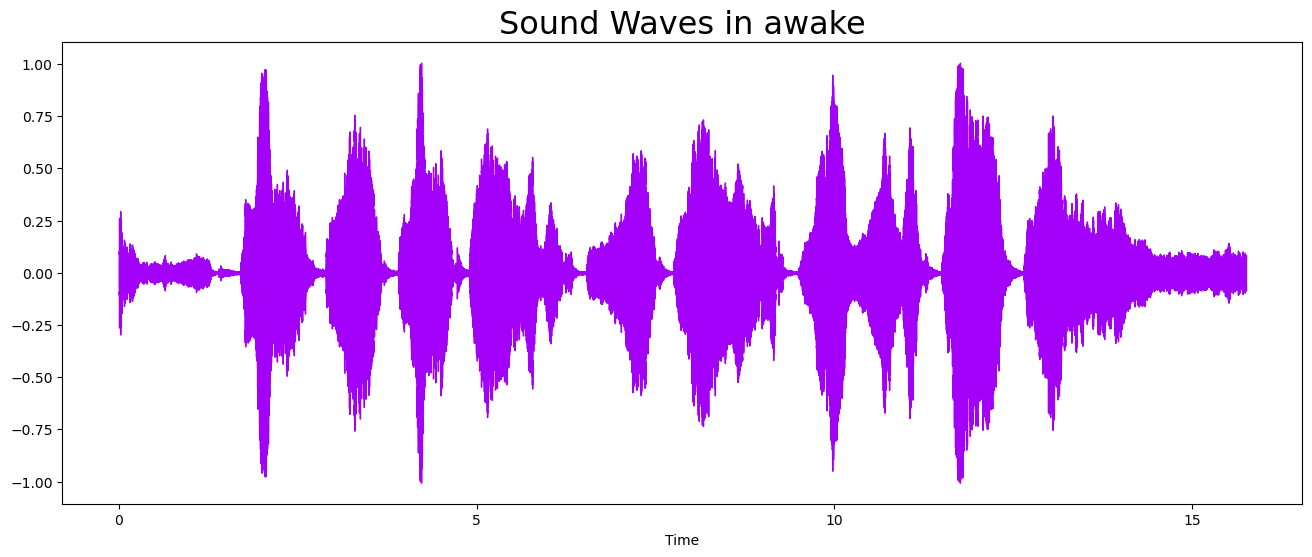

In [6]:

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in awake", fontsize = 23);

## Short-Time Fourier Transform (STFT)
STFT provides the time-localized frequency information for situations in which frequency components of a signal vary over time, whereas the standard Fourier transform provides the frequency information averaged over the entire signal time interval.

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.


### librosa.stft(y, *, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='constant', out=None)
y= input signal np.ndarray 
Returns:
  D:np.ndarray [shape=(…, 1 + n_fft/2, n_frames), dtype=dtype]
      Complex-valued matrix of short-term Fourier transform coefficients.

  If a pre-allocated out array is provided, then D will be a reference to out.

  If out is larger than necessary, then D will be a sliced view: D = out[…, :n_frames ]
  
    np.abs(D[..., f, t]) is the magnitude of frequency bin f at frame t, and

    np.angle(D[..., f, t]) is the phase of frequency bin f at frame t

In [7]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
# return the magnitude of frequency bin f at frame t
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 679)


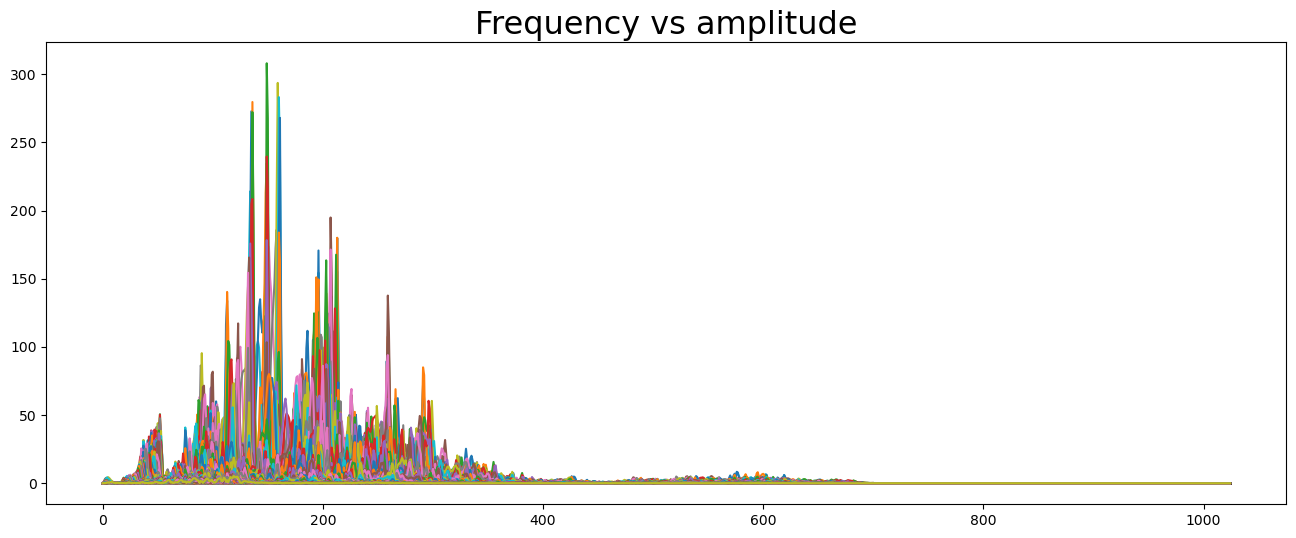

In [8]:
plt.figure(figsize = (16, 6))
plt.plot(D);
plt.title("Frequency vs amplitude", fontsize = 23);

## Spectrogram

* A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.

* A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

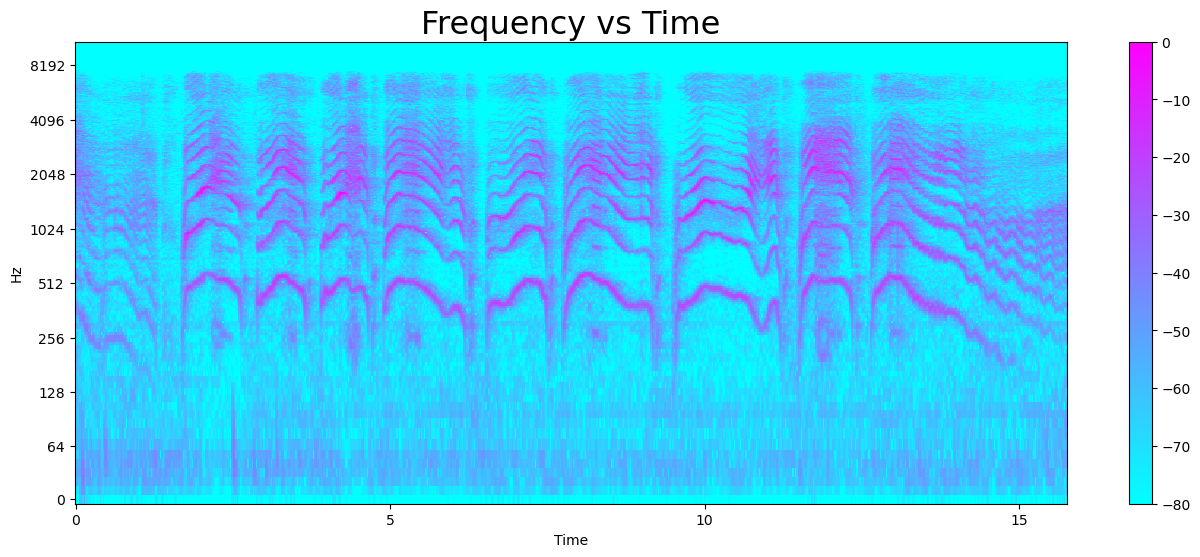

In [9]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)
# Creating the Spectogram
plt.figure(figsize = (16, 6))
#Display a spectrogram
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.title("Frequency vs Time", fontsize = 23);
plt.colorbar();

### Mel Spectrogram

* The mel scale (after the word melody) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments.

A formula to convert f hertz into m mels is:

$$m=2595\log_{10}\left(1+\frac{f}{700}\right)$$

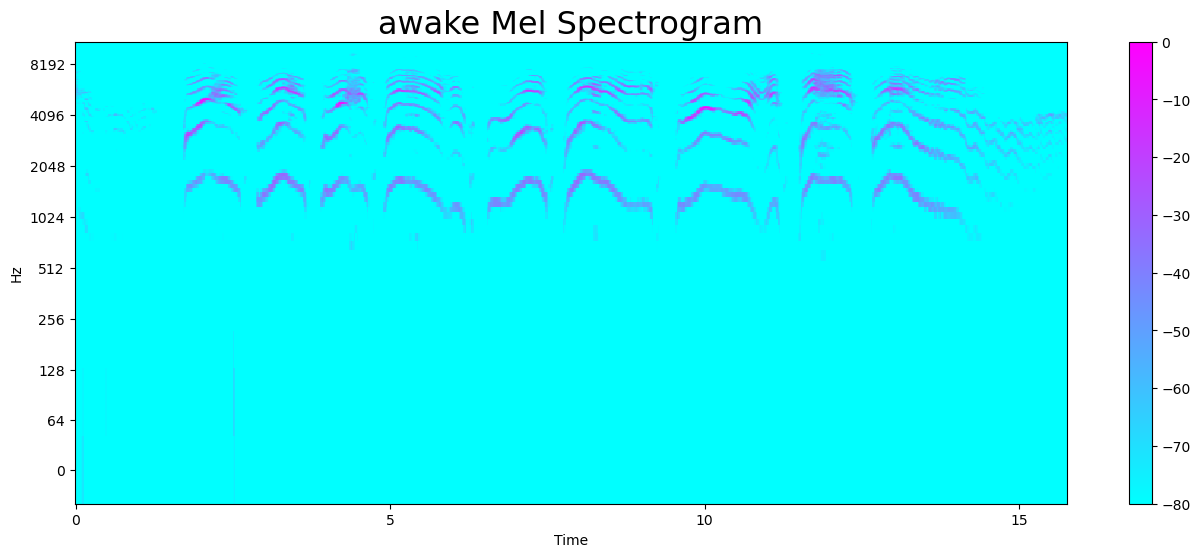

In [10]:
y, sr = librosa.load(f'{general_path}/archive/train/awake/awake_0.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("awake Mel Spectrogram", fontsize = 23);

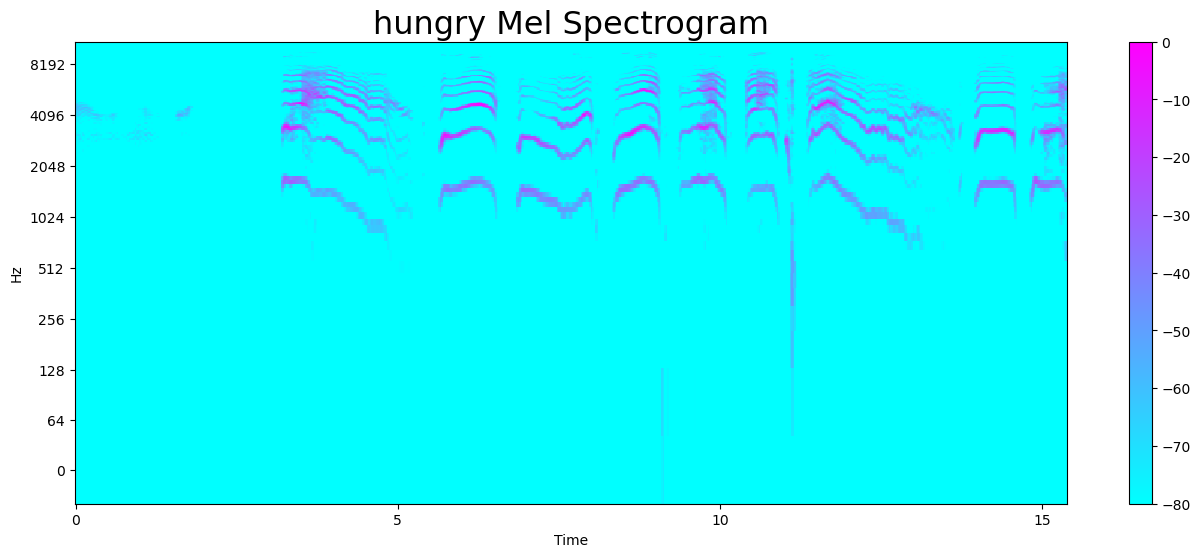

In [11]:
y, sr = librosa.load(f'{general_path}/archive/train/hungry/hungry_0.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("hungry Mel Spectrogram", fontsize = 23);

## Audio Features

### Zero Crossing Rate¶
* the rate at which the signal changes from positive to negative or back.

In [12]:
# Total zero_crossings in our 1 data
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))



TypeError: 'int' object is not callable

## Harmonics and Perceptrual
* Harmonics are characteristichs that human ears can't distinguish (represents the sound color)
* Perceptrual understanding shock wave represents the sound rhythm and emotion


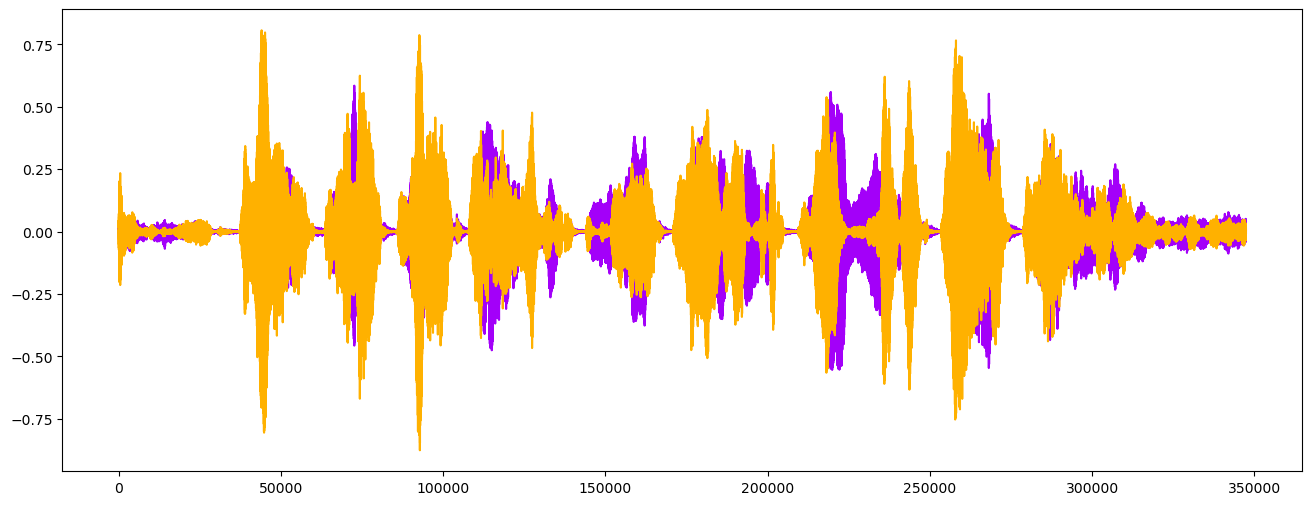

In [13]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

## Tempo BMP (beats per minute)
Dynamic programming beat tracker.



In [14]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

198.76802884615384

## Spectral Centroid
* indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [15]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [2699.12236216 2721.82615143 2767.71893368 2733.35770048 2715.09065025
 2587.58509827 2410.28416903 2421.08877527 2208.37822045 2092.83423647
 2154.58560705 2184.75214746 2137.09577395 2091.26983155 2068.521319
 2044.12400639 2062.56198653 2020.0019355  1979.39013359 1841.27733554
 1766.7711598  1883.94566237 2065.86283506 2057.31973992 2075.35148984
 2134.26939537 2086.85670813 2059.41885384 2017.50418722 2043.94937141
 2071.59777835 2034.9041642  2076.95975081 2118.55484384 2116.01106125
 2147.67538039 2125.84477015 2105.22818032 2126.10417254 2053.00416355
 2118.97142403 2154.36522665 2138.84275841 2265.29799757 2292.59140206
 2495.77890053 2629.99687268 2491.00849257 2340.43539867 2274.07350316
 2261.98879346 2215.6314751  2142.44259068 1975.76771762 1911.32363248
 1831.98111075 1981.99115038 2246.59624946 2284.01329835 2470.16387196
 2466.39556365 2598.83755973 2991.57072312 3343.27411905 3318.97260363
 3147.47762377 3205.21400291 3222.5233855  3105.42258158 2820.516376

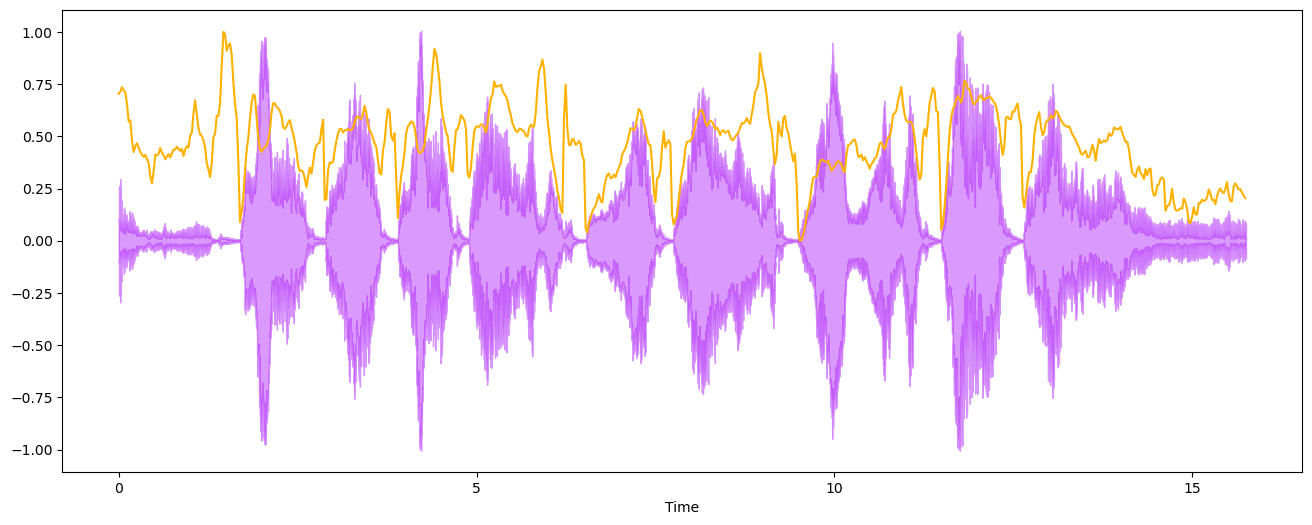

In [16]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

## Spectral Rolloff
* is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies

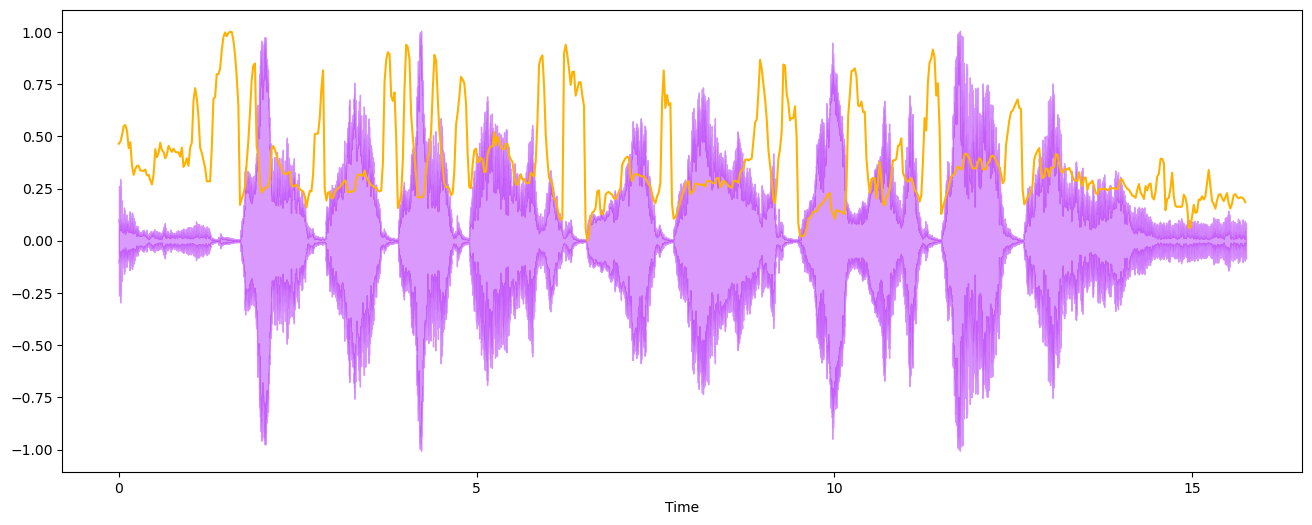

In [17]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

## Mel-Frequency Cepstral Coefficients:
* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

mfccs shape: (20, 679)
[[-1.9665587e+02 -1.7274782e+02 -1.9095055e+02 ... -2.5742807e+02
  -2.5880829e+02 -2.7210611e+02]
 [ 4.5314804e+01  4.6663338e+01  4.3102676e+01 ...  1.1341397e+02
   1.1754965e+02  1.1967810e+02]
 [-1.1642374e+02 -1.1808086e+02 -1.0888928e+02 ... -5.8094692e+01
  -5.3380352e+01 -4.7017288e+01]
 ...
 [-4.1459990e+00  7.7153549e-02  5.4957280e+00 ...  1.1126461e+01
   9.5747986e+00  9.1442852e+00]
 [-2.3654404e+00 -4.8122105e-01  2.6201320e+00 ... -6.0878849e+00
  -6.4686785e+00 -4.9953871e+00]
 [ 1.4772890e+01  1.0040700e+01  1.3116324e+01 ... -2.0194056e+00
  -3.2813697e+00 -5.2948279e+00]]


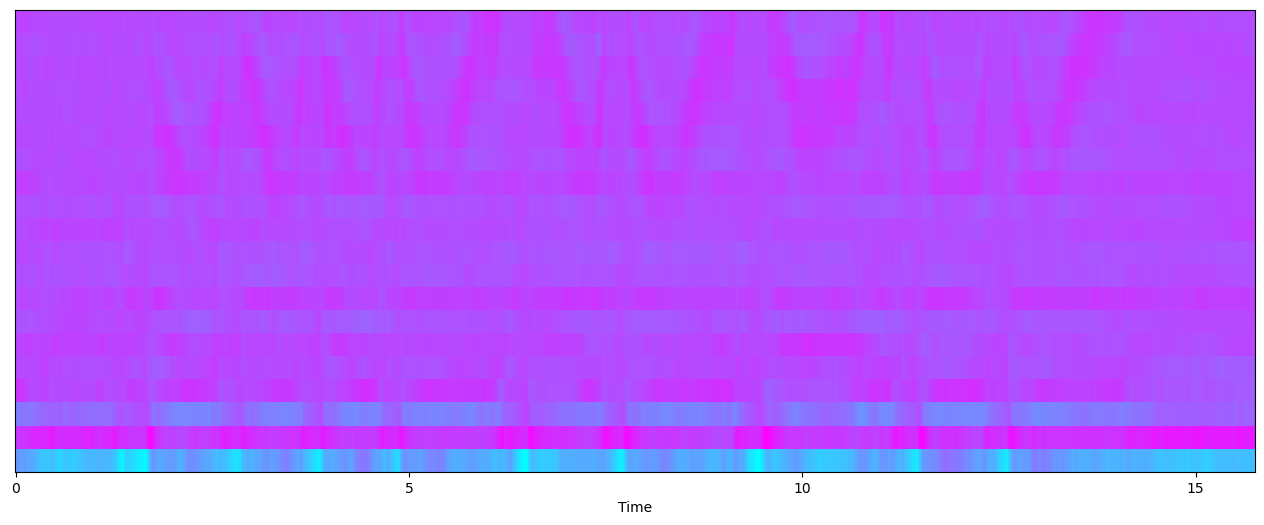

In [18]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)
print(mfccs)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

## Perform Feature Scaling
### Data needs to be scaled:
scaling: transforming your data so that it fits within a specific scale, like 0-100 or 0-1. You want to scale data when you're using methods based on measures of how far apart data points, like support vector machines, or SVM or k-nearest neighbors, or KNN
 
 #### sklearn.preprocessing.scale()
 * Standardize a dataset along any axis . preprocessing.scale() method is helpful in standardization of data points. It would divide by the standard deviation and substract the mean for each data point.

Mean: -1.5449805e-09 

Var: 1.0


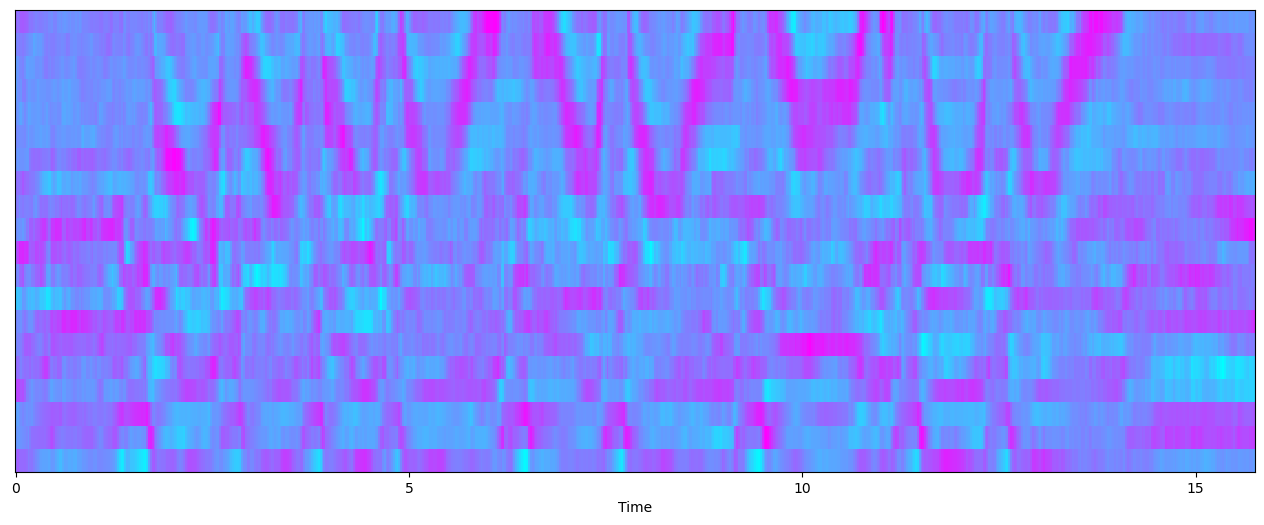

In [19]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

## Chroma Frequencies
* Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

Chromogram shape: (12, 70)


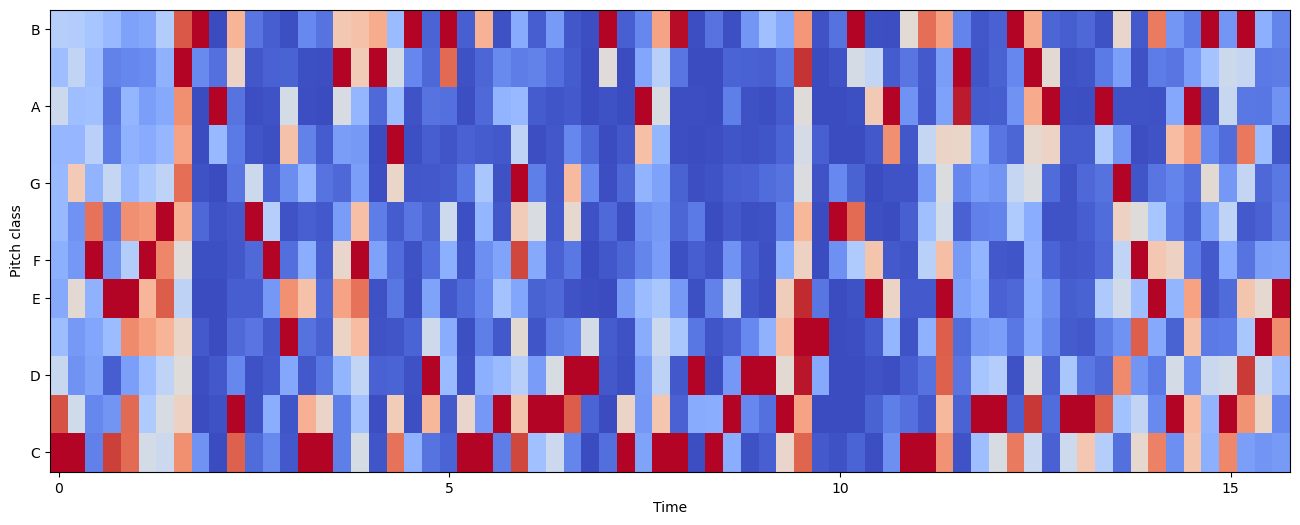

In [20]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

In [21]:
data = pd.read_csv('data_splitted.csv')
data
df = pd.DataFrame(data)
# df
# df = df.iloc[ : , [0,1]] # columns 1 and 2


header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
df.columns = header 
df

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,hungry_0_1.wav,0.312716,0.096467,2373.864888,1549.539116,3914.156588,0.162748,-256.075745,50.916206,-104.481178,...,-21.739847,11.760919,-8.281605,12.958506,9.181945,8.325441,0.700123,-6.669662,1.941499,hungry
1,hungry_0_2.wav,0.246606,0.112298,2256.352554,1676.870916,4030.767165,0.128369,-275.599518,46.449654,-87.007782,...,-17.127180,12.610085,-6.240648,25.427092,12.574850,13.174425,8.849941,-3.155222,10.402691,hungry
2,hungry_0_3.wav,0.339525,0.098610,2426.211080,1544.056989,3910.678148,0.165865,-231.041031,63.659592,-112.387047,...,-19.521851,11.788096,-4.382726,21.028105,5.370878,5.966624,-4.283737,-6.099944,4.506306,hungry
3,hungry_0_4.wav,0.246216,0.062294,2016.698610,1508.653253,3515.709510,0.119501,-286.828003,76.468071,-97.555740,...,-15.456632,8.579997,-3.701476,15.236769,7.315352,-0.179822,-0.825169,-4.546344,9.381934,hungry
4,hungry_0_5.wav,0.205297,0.130842,2112.363462,1376.732075,3195.780676,0.120692,-164.087494,99.413712,-125.496193,...,-19.158922,13.084662,-0.951993,26.491486,-4.212042,-2.120291,-22.204575,-8.208257,12.038486,hungry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,uncomfortable_99_2.wav,0.284101,0.117246,1988.503294,1652.107897,3873.326322,0.109428,-225.434952,94.595947,-71.996185,...,0.614535,4.430320,-4.886551,8.206274,-1.561478,10.721548,7.993068,15.483581,12.117250,uncomfortable
2891,uncomfortable_99_3.wav,0.197702,0.191735,1785.828329,1341.332549,2731.735276,0.108549,-224.025711,76.097443,-93.157784,...,-1.036358,3.984003,-5.749381,0.682336,-6.921834,12.269647,17.725574,25.714598,22.531544,uncomfortable
2892,uncomfortable_99_4.wav,0.230572,0.134774,1738.608583,1467.318854,3119.747033,0.097269,-237.142273,89.467125,-56.951775,...,-3.543912,6.536152,-2.936754,0.763929,-2.379932,-2.572868,0.265817,4.001442,14.736229,uncomfortable
2893,uncomfortable_99_5.wav,0.229144,0.124574,1782.891318,1496.735818,3304.435660,0.101134,-232.507156,92.212921,-62.895096,...,-3.573676,7.494671,-5.145485,3.444414,-6.583947,-2.108324,5.951846,10.771128,20.730349,uncomfortable


## Principal Component Analysis - to visualize possible groups
1. Normalization
2. PCA
3. The Scatter Plot


### preprocessing.MinMaxScaler()
* Transform features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
* The transformation is given by: 
\
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
\
X_scaled = X_std * (max - min) + min
\
where min, max =feature_range:tuple (min, max), default=(0, 1) (Desired range of transformed data).
\

* fit_transform(X, y=None, **fit_params)
\
 Fit to data, then transform it.
 
 
 ### Principal component analysis:
 
 * Principal component analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.
 * Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.
* the idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible.
 

In [22]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
# print(cols)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2' ])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

array([0.20369296, 0.16950471])

In [23]:
finalDf

,principal component 1,principal component 2,label
0,-0.237779,-0.156233,hungry
1,-0.310940,-0.073182,hungry
2,-0.255942,-0.172932,hungry
3,-0.130086,0.037732,hungry
4,-0.355167,0.087017,hungry
...,...,...,...
2890,-0.110113,0.171979,uncomfortable
2891,-0.231837,0.353699,uncomfortable
2892,-0.068030,0.341817,uncomfortable
2893,-0.054222,0.229551,uncomfortable


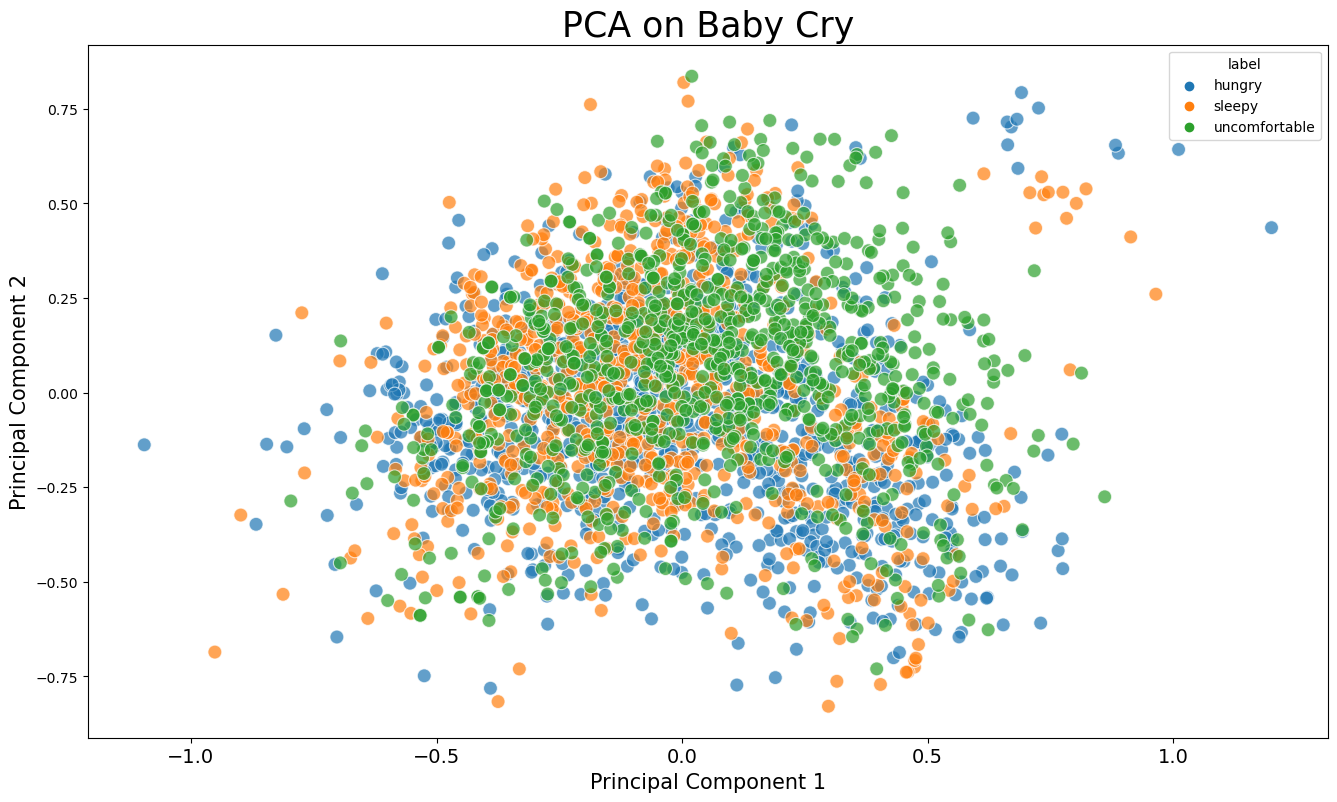

In [24]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Baby Cry', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

## Machine Learning Classification

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve,auc,f1_score,precision_score,recall_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [26]:
# data = finalDf
data = data.iloc[0:, 1:] 
data.head()

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.096467,2373.864888,1549.539116,3914.156588,0.162748,-256.075745,50.916206,-104.481178,21.164339,-14.781761,...,-21.739847,11.760919,-8.281605,12.958506,9.181945,8.325441,0.700123,-6.669662,1.941499,hungry
1,0.112298,2256.352554,1676.870916,4030.767165,0.128369,-275.599518,46.449654,-87.007782,18.369684,-19.181421,...,-17.127180,12.610085,-6.240648,25.427092,12.574850,13.174425,8.849941,-3.155222,10.402691,hungry
2,0.098610,2426.211080,1544.056989,3910.678148,0.165865,-231.041031,63.659592,-112.387047,29.588585,-22.771090,...,-19.521851,11.788096,-4.382726,21.028105,5.370878,5.966624,-4.283737,-6.099944,4.506306,hungry
3,0.062294,2016.698610,1508.653253,3515.709510,0.119501,-286.828003,76.468071,-97.555740,9.300261,-36.046848,...,-15.456632,8.579997,-3.701476,15.236769,7.315352,-0.179822,-0.825169,-4.546344,9.381934,hungry
4,0.130842,2112.363462,1376.732075,3195.780676,0.120692,-164.087494,99.413712,-125.496193,28.565971,-46.449696,...,-19.158922,13.084662,-0.951993,26.491486,-4.212042,-2.120291,-22.204575,-8.208257,12.038486,hungry


#### Features and Target variable
* creates the target and feature variables
* normalizes the data


In [50]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)
X

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.305797,0.397086,0.430563,0.421296,0.418483,0.750766,0.426444,0.141014,0.536676,0.671343,...,0.647124,0.360925,0.531984,0.453537,0.519428,0.558245,0.479293,0.340904,0.330562,0.390478
1,0.356027,0.374560,0.468925,0.435715,0.326056,0.726869,0.408548,0.201701,0.517951,0.641120,...,0.633068,0.429933,0.542802,0.477582,0.674679,0.605001,0.536479,0.435828,0.375181,0.502740
2,0.312598,0.407120,0.428912,0.420866,0.426864,0.781408,0.477504,0.113556,0.593122,0.616461,...,0.564916,0.394108,0.532330,0.499472,0.619906,0.505727,0.451475,0.282855,0.337795,0.424508
3,0.197375,0.328620,0.418246,0.372026,0.302214,0.713126,0.528824,0.165067,0.457182,0.525263,...,0.593095,0.454925,0.491459,0.507498,0.547796,0.532523,0.378987,0.323138,0.357520,0.489197
4,0.414862,0.346958,0.378502,0.332465,0.305415,0.863359,0.620761,0.068027,0.586270,0.453801,...,0.384037,0.399537,0.548848,0.539891,0.687932,0.373671,0.356102,0.074124,0.311028,0.524444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,0.371723,0.323215,0.461464,0.416247,0.275131,0.788270,0.601458,0.253838,0.415720,0.485083,...,0.568875,0.695357,0.438593,0.493536,0.460256,0.410197,0.507551,0.425848,0.611818,0.525489
2891,0.608060,0.284364,0.367837,0.275084,0.272768,0.789995,0.527339,0.180341,0.346109,0.551951,...,0.562834,0.670658,0.432907,0.483370,0.366573,0.336329,0.525809,0.539206,0.741710,0.663664
2892,0.427337,0.275312,0.405793,0.323063,0.242444,0.773940,0.580908,0.306089,0.357278,0.488527,...,0.591181,0.633144,0.465421,0.516507,0.367589,0.398918,0.350765,0.335845,0.466042,0.560237
2893,0.394974,0.283801,0.414656,0.345901,0.252835,0.779614,0.591910,0.285447,0.430576,0.520909,...,0.569093,0.632699,0.477632,0.490485,0.400965,0.340985,0.356243,0.402073,0.551989,0.639766


### Splitting the data into training and testing
* 80% - 20% split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Creating a Predefined function to assess the accuracy of a model
* input is the model
* fits the model on the training dataset
* predicts on the testing features
* compares the predictions with the actuals

$$accuracy\_score=\left(\frac{Number\ of\ correct\ prediction}{Total\ number\ of\ correct\ prediction}\right)$$
$$recall\_score=\left(\frac{True\ positive}{True\ positive\ +\ False\ Negative}\right)$$
$$precision\_score=\left(\frac{True\ positive}{True\ positive\ +\ False\ positive}\right)$$
$$F1\_score=\left(\frac{2\ precision * recall}{precision\ +\ Recall}\right)$$

In [29]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f'{title}')
    print('confusion matrix\n',confusion_matrix(y_test, preds))
    print('precision_score==>',precision_score(y_test,preds,average='macro'))
    print('recall_score==>',recall_score(y_test,preds,average='macro'))
    print('f1_score==>',f1_score(y_test,preds,average='macro'))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

### Trying 5 different models to assess their performance
We tried 10 classification models, the best performing model was Support Vector Machine.

In [30]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")


# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")


# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=46)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovr",gamma=3 ,C=7)
model_assess(svm, "Support Vector Machine")



# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 10), random_state=1)
model_assess(nn, "Neural Nets")



Naive Bayes
confusion matrix
 [[152  38  18]
 [ 76  86  22]
 [ 27  47 113]]
precision_score==> 0.6125214998280014
recall_score==> 0.6008128699944556
f1_score==> 0.6019334658695407
Accuracy Naive Bayes : 0.60622 

KNN
confusion matrix
 [[166  37   5]
 [ 47 127  10]
 [ 28  24 135]]
precision_score==> 0.7547761984638474
recall_score==> 0.7367398160237034
f1_score==> 0.7411345259856453
Accuracy KNN : 0.73921 

Random Forest
confusion matrix
 [[167  31  10]
 [ 39 129  16]
 [ 18  21 148]]
precision_score==> 0.7696058697499448
recall_score==> 0.7651384740579115
f1_score==> 0.7666473538515305
Accuracy Random Forest : 0.76684 

Support Vector Machine
confusion matrix
 [[183  20   5]
 [ 26 152   6]
 [ 15  12 160]]
precision_score==> 0.859574585618636
recall_score==> 0.8538365406971544
f1_score==> 0.8557213091157712
Accuracy Support Vector Machine : 0.85492 

Neural Nets
confusion matrix
 [[152  37  19]
 [ 55 115  14]
 [ 19  29 139]]
precision_score==> 0.7053550075290788
recall_score==> 0.6996949

In [31]:

rforest.fit(X_train, y_train)
preds = rforest.predict(X_test)
cm=confusion_matrix(y_test, preds)

print('confusion matrix\n',cm)

confusion matrix
 [[167  31  10]
 [ 39 129  16]
 [ 18  21 148]]


Text(0.5, 1.0, 'Random forest')

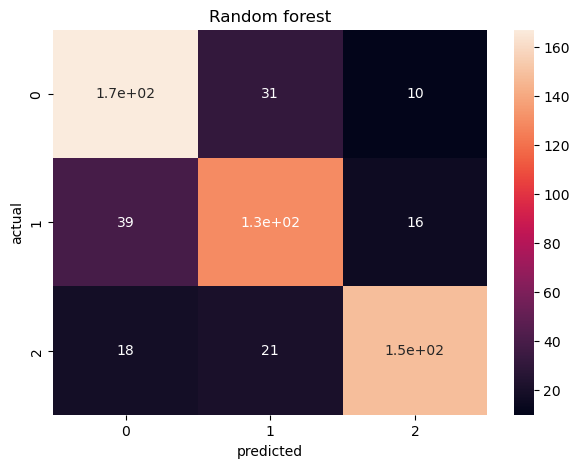

In [32]:
import seaborn as sn
plt.figure(figsize=(7,5))
sn.heatmap(cm,annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Random forest')

In [33]:

svm.fit(X_train, y_train)
preds = svm.predict(X_test)
cm=confusion_matrix(y_test, preds)

print('confusion matrix\n',cm)

confusion matrix
 [[183  20   5]
 [ 26 152   6]
 [ 15  12 160]]


Text(0.5, 1.0, 'SVM')

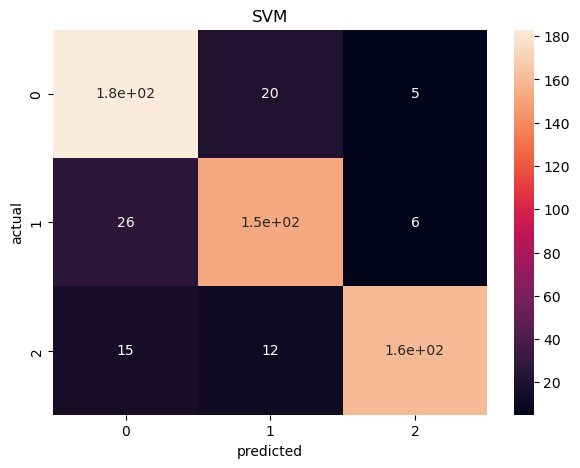

In [34]:
plt.figure(figsize=(7,5))
sn.heatmap(cm,annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('SVM')

In [44]:
# df['label'].unique()
lookup_name={0:'hungry',1:'sleepy',2:'uncomfortable'}
lookup_name

{0: 'hungry', 1: 'sleepy', 2: 'uncomfortable'}

In [35]:
import pickle


In [ ]:
# import pickle

# # Assuming you have a trained classification model stored in a variable called 'model'
# model = svm

# # Dump the model to a pickle file
# with open('baby-cry_classification_model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [49]:
pick1 = {
    'norma':min_max_scaler,
    'svmp':svm,
    'lgn':lookup_name
}
pickle.dump( pick1, open( 'baby_cry_classification_model_final.pkl', "wb" ) )

In [46]:
with open('baby_cry_classification_model.pkl','rb') as pickled:
        model = pickle.load(pickled)
    
svmp=model['svmp']
norma=model['norma']
lcn=model['lgn']

In [47]:
lcn[1]

'sleepy'